**NOTE IMPORATANTE** : Si un package manque, vous pouvez l’installer en utilisant la commande "Pip install ": par example , parmi les packages on aura besoin dans ce projet
```bash
pip install optuna optuna-integration[tfkeras] scikeras
```

**Introduction**
----------------

La classification de texte est une tâche essentielle dans le traitement automatique du langage naturel (NLP), où l'objectif est d'attribuer une catégorie prédéfinie à un document ou un contenu textuel. Dans ce projet, nous construisons un modèle de classification de texte basé sur une architecture **LSTM** (Long Short-Term Memory). Cette méthode est bien adaptée à l'analyse de séquences, car elle capture efficacement les dépendances contextuelles dans les données textuelles.

### **Objectif du projet**

Le but est de classer des documents textuels en cinq catégories distinctes :

*   **business** (label 0)
    
*   **entertainment** (label 1)
    
*   **politics** (label 2)
    
*   **sport** (label 3)
    
*   **tech** (label 4)
    
### **Approche**

Pour résoudre le problème de classification de texte en 5 catégories, l'approche suivante est adoptée :

1.  **Prétraitement des Données** :
    
    *   Les textes bruts sont tokenisés à l'aide d'un **tokenizer** (comme celui fourni par Keras), qui convertit chaque mot en un identifiant numérique unique.
        
    *   Le texte est ensuite transformé en séquences de longueur fixe (padding) pour garantir une entrée cohérente au modèle.
        
2.  **Représentation des Mots** :
    
    *   Utilisation des vecteurs préentraînés **GloVe** (Global Vectors for Word Representation) pour générer une représentation vectorielle dense des mots.
        
    *   Ces vecteurs capturent des relations sémantiques et contextuelles entre les mots, par exemple, des mots similaires auront des vecteurs proches dans l'espace vectoriel.
        
3.  **Passage par une Couche d'Embedding** :
    
    *   Une couche **Embedding** est initialisée avec les vecteurs GloVe pour fournir une représentation vectorielle continue des mots. Cette couche permet au modèle d'utiliser les relations préapprises tout en s'adaptant au contexte spécifique du projet.
        
4.  **Modélisation avec une Architecture LSTM** :
    
    *   Une couche **LSTM** (Long Short-Term Memory) est utilisée pour capturer les dépendances à long terme et contextuelles dans les données textuelles.
        
    *   LSTM est particulièrement efficace pour gérer les séquences, car elle résout le problème du gradient qui disparaît dans les réseaux récurrents traditionnels (RNN).
        
5.  **Couches Supérieures** :
    
    *   Des couches entièrement connectées (Dense) suivent la couche LSTM pour effectuer la classification.
        
    *   Une activation **softmax** est utilisée en sortie pour générer des probabilités pour chacune des 5 classes.
        
6.  **Évaluation** :
    
    *   Les performances du modèle sont mesurées à l'aide de plusieurs métriques

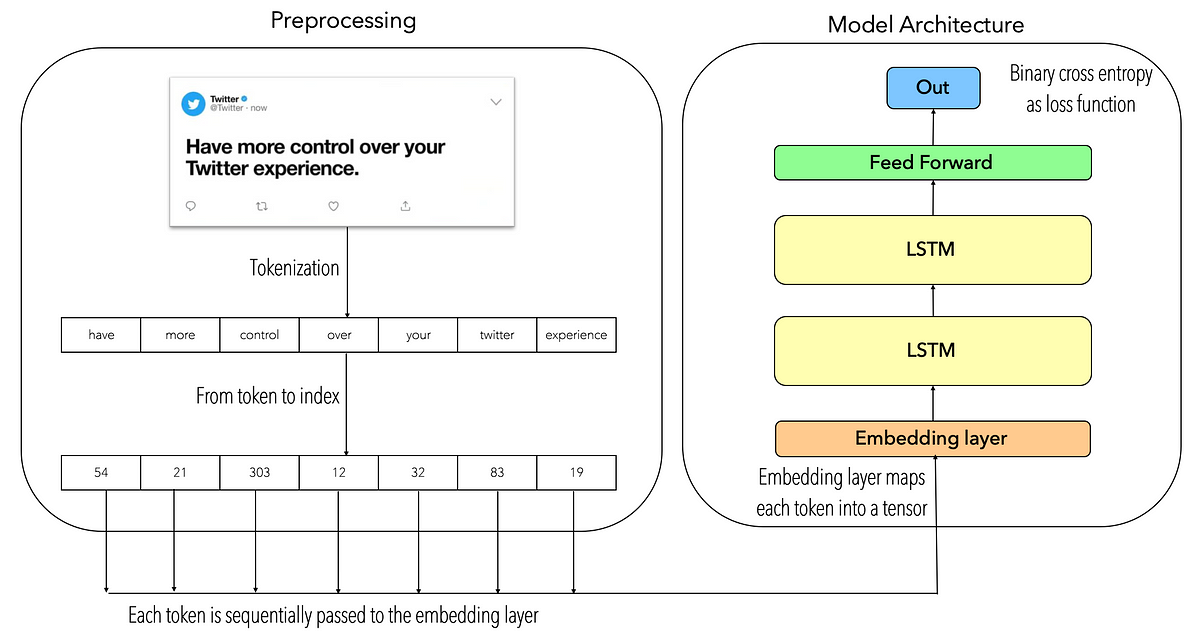

## **Montage de Google Drive**

Montage de Google Drive dans Colab pour accéder aux fichiers nécessaires, comme le dataset et les vecteurs GloVe.

In [ ]:
# Mounting google drive to access data and glove model
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#import all required packages and modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input,  Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant


import time


## **Copie et Décompression des Fichiers**
Copie du dataset et des vecteurs GloVe depuis Google Drive vers l'environnement local, suivi de la décompression des fichiers GloVe.

In [ ]:
# copying dataset and embedding from drive. Unpacking the compressed files
!cp /content/gdrive/MyDrive/cleaned_dataset_final.csv .
!cp /content/gdrive/MyDrive/My_models/glove.6B.zip .
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## **Fixation des Seeds pour la Reproductibilité**

Ce code fixe une valeur de seed pour garantir la reproductibilité des résultats en contrôlant les générateurs aléatoires de Python, NumPy, et TensorFlow.

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

# Seed value
seed_value = 123

# 1. Set `PYTHONHASHSEED` environment variable
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set Python's random generator
random.seed(seed_value)

# 3. Set NumPy's random generator
np.random.seed(seed_value)

# 4. Set TensorFlow's random generator
tf.random.set_seed(seed_value)


## **Chargement et Division du Dataset**

Chargement du dataset depuis un fichier CSV, séparation en caractéristiques et étiquettes, puis division en ensembles d'entraînement et de test avec un échantillonnage stratifié pour préserver la distribution des classes.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('cleaned_dataset_final.csv')

# Display the first few rows for verification
print(df.head())

# Split the dataset into features and target
y = df['Label']  # Target variable
X = df.drop(['Label'], axis=1)  # Features: 'Content' and 'Document Length'

# Perform stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=123
)

# Reset indices for cleaner data handling
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


                                             Content  Label  Document Length
0  lufthansa fly profit german airline lufthansa ...      0               65
1  winndixie file bankruptcy supermarket winndixi...      0              133
2  growing fed saw expand federal reserve beige b...      0              100
3  saab build cadillacs sweden motor largest car ...      0              306
4  voted passed ratesetting body shown monetary c...      0              146


In [ ]:
#Parameters for hyperparameter  tuning
dropout = 0.3
bidirectional = False
EMBEDDING_DIM = 200
traina = True #embeedding layer trainable

In [ ]:
X_train['Content']

,Content
0,wireless_fidelity vane granger Republic_of_Per...
1,download chart debut delayed inclusion downloa...
2,dal maso replace bergamasco dal maso handed ta...
3,keanu reef hollywood actor keanu reef known ma...
4,digital Guru drift substitute personal_compute...
...,...
2351,black sabbath rock album poll black sabbath to...
2352,intel unveils laser breakthrough intel unveile...
2353,bosvelt optimistic manchester city paul bosvel...
2354,mild winter drive oil oil fallen driven foreca...


## **Extraction des Textes sous forme de numpy pour le Modèle**

Extraction des données textuelles à partir de la colonne **Content** des ensembles d'entraînement et de test sous forme de tableaux NumPy.

In [ ]:
texts = np.array(X_train['Content'])  # Use 'Content' as the column name
test_text = np.array(X_test['Content'])  # Use 'Content' as the column name

In [ ]:
y_test

,Label
0,4
1,4
2,3
3,4
4,1
...,...
584,4
585,0
586,3
587,3


## **Calcul et Visualisation des Longueurs de Séquences**

Calcul des longueurs des séquences dans le dataset d'entraînement et affichage de leur distribution sous forme d'histogramme. La longueur maximale des séquences est définie à **1000** pour le modèle.

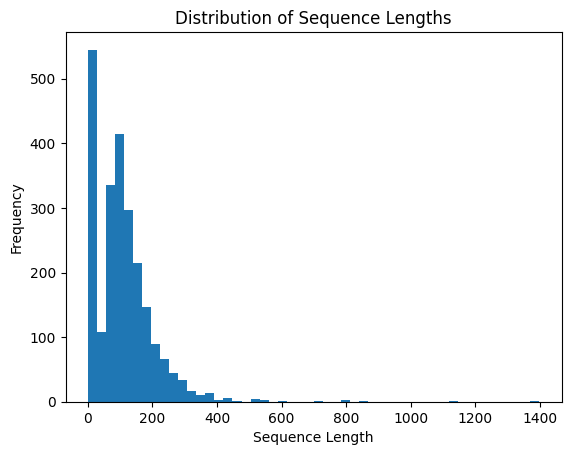

In [ ]:
# Calculate the length of each sequence
sequence_lengths = [len(text.split()) for text in X_train["Content"]]

# Plot histogram to visualize sequence length distribution
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


### **Importance de MAX\_SEQUENCE\_LENGTH = 1000**

Fixer une **longueur maximale de séquence** est crucial pour plusieurs raisons dans un projet de traitement de texte :

1.  **Uniformisation des Entrées** :
    
    *   Les modèles de deep learning, notamment les architectures comme LSTM, nécessitent des entrées de longueur uniforme pour chaque séquence. Cela permet de les traiter en batchs et de faciliter l'entraînement. En définissant MAX\_SEQUENCE\_LENGTH = 1000, on s'assure que toutes les séquences de texte aient la même longueur, soit en les tronquant, soit en les complétant (padding).
        
2.  **Limitation de la Complexité du Modèle** :
    
    *   En limitant la longueur des séquences, on réduit la quantité de données que le modèle doit traiter à chaque étape, ce qui optimise les performances et l'efficacité computationnelle. Si la longueur des séquences était trop grande, cela pourrait entraîner une surcharge mémoire et augmenter le temps d'entraînement.

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

## **Chargement des Vecteurs GloVe et Préparation des Embeddings**

**Description :**Chargement des vecteurs préentraînés GloVe depuis un fichier, puis création d'un dictionnaire **embeddings\_index** associant chaque mot à son vecteur dense. Ce processus est essentiel pour la conversion des mots en représentations numériques que le modèle LSTM peut utiliser. Le nombre total de vecteurs trouvés est affiché.

In [ ]:
#Choose max sequence length with optimal sequence length based on histo plot
#Load glove model embeddings corresponding to best dimensions from hyperparameter tuning
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 25000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.'+str(EMBEDDING_DIM)+'d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### **Tokenisation, Padding et Préparation des Données d'Entraînement**

**Description :**Ce code utilise un **tokenizer** pour transformer les textes en séquences numériques, puis applique un **padding** pour assurer des entrées de longueur uniforme. Il sépare également les données en ensembles d'entraînement, de validation et de test.

### **Explication Détailée**

1.  **Tokenisation** :
    
    *   Le **tokenizer** de Keras est utilisé pour convertir chaque texte en une séquence d'entiers, où chaque entier représente un mot dans le vocabulaire.
        
    *   Le paramètre nb\_words=MAX\_NB\_WORDS permet de limiter le vocabulaire aux 25 000 mots les plus fréquents dans le dataset. Les mots non présents dans ce vocabulaire sont ignorés.
        
2.  **Padding des Séquences** :
    
    *   Après la tokenisation, les séquences de mots sont remplies de zéros ou tronquées à **MAX\_SEQUENCE\_LENGTH = 1000** pour uniformiser la longueur des séquences et les rendre compatibles avec le modèle.
        
3.  **Conversion des Étiquettes** :
    
    *   Les étiquettes de classe sont converties en **one-hot encoding** avec la fonction to\_categorical. Cela transforme les étiquettes en vecteurs binaires, où chaque classe est représentée par un vecteur de longueur égale au nombre de classes (5 dans ce cas).
        
4.  **Séparation des Données** :
    
    *   Le jeu de données est mélangé de manière aléatoire pour éviter des biais liés à l'ordre des données.
        
    *   Une fraction de **20%** des données est utilisée pour la validation, tandis que **64%** est utilisé pour l'entraînement et **16%** pour la validation. Cela permet de tester le modèle de manière plus réaliste en réservant une portion pour l'évaluation.
        

### **Importance du Padding et de la Tokenisation**

*   **Padding** : Garantit que toutes les séquences ont la même longueur, ce qui est essentiel pour le traitement par des réseaux de neurones, notamment pour les couches LSTM.
    
*   **Tokenisation et Limitation du Vocabulaire** : La tokenisation permet de convertir les textes en séquences d'entiers, tandis que la limite du vocabulaire avec MAX\_NB\_WORDS réduit la complexité en ne gardant que les mots les plus fréquents et pertinents.

In [ ]:
#Create data with tokenizer word_index. Neglect words which are not in word_index
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

#Split training and validation data with 20% split. So final is training 64%, validation 16% and test 20% of whole data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 28658 unique tokens.
Shape of data tensor: (2356, 1000)
Shape of label tensor: (2356, 5)


## **Création de la Matrice d'Embedding GloVe et Initialisation de la Couche d'Embedding**

On va creer une matrice d'**embedding** GloVe en associant chaque mot de word\_index à son vecteur d'embedding, puis initialise une couche d'**Embedding** Keras avec cette matrice.

1.  **Création de la Matrice d'Embedding (embedding\_matrix)** :
    
    *   La matrice **embedding\_matrix** est initialisée comme une matrice de zéros de taille (len(word\_index) + 1, EMBEDDING\_DIM).
        
        *   La taille (len(word\_index) + 1) correspond au nombre de mots dans le vocabulaire plus 1 pour l'index de padding (0).
            
        *   **EMBEDDING\_DIM** est la dimension des vecteurs d'embedding (par exemple, 100 ou 300).
            
    *   Pour chaque mot dans word\_index, le code cherche son vecteur d'embedding dans **embeddings\_index** (qui contient les vecteurs GloVe). Si le mot est trouvé, son vecteur est affecté à la matrice à la position correspondante. Si le mot n'est pas trouvé dans les vecteurs GloVe, la ligne de la matrice correspondante reste une série de zéros (représentation pour les mots inconnus).
        
2.  **Initialisation de la Couche d'Embedding Keras** :
    
    *   La couche d'**Embedding** est ensuite initialisée en utilisant la **matrice d'embedding** GloVe comme poids de la couche.
        
    *   **weights=\[embedding\_matrix\]** permet de passer les vecteurs GloVe comme poids initialisés dans la couche.
        
    *   **input\_length=MAX\_SEQUENCE\_LENGTH** spécifie la longueur des séquences d'entrée, que nous avons définie à 1000.
        
    *   **trainable=traina** : La variable traina détermine si les poids des embeddings GloVe doivent être entraînables ou non. Si traina=True, les vecteurs d'embedding GloVe seront ajustés pendant l'entraînement ; sinon, ils resteront fixes.
        

### **Pourquoi Utiliser GloVe pour l'Embedding ?**

*   **Pré-entraînement** : GloVe est pré-entraîné sur de grandes quantités de texte, ce qui permet d'obtenir des embeddings plus riches, capturant des relations sémantiques et syntaxiques entre les mots.
    
*   **Matrice d'Embedding** : En utilisant cette matrice pré-entraînée, le modèle peut bénéficier des connaissances sémantiques déjà apprises, ce qui peut améliorer ses performances, surtout lorsqu'il n'y a pas assez de données pour entraîner un modèle d'embedding à partir de zéro.

In [ ]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=traina)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
#Map label name to its index
labels_index = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

# RNN (LSTM)

### **Architecture du Modèle LSTM avec Embedding GloVe et LSTM Bidirectionnel**

Définition de l'architecture du modèle LSTM avec la couche d'**Embedding** GloVe. Le modèle utilise une couche **LSTM** (possiblement bidirectionnelle) suivie d'une couche **Dense** pour la classification multiclasse.



1.  **Entrée du Modèle** :
    
    *   **Input(shape=(MAX\_SEQUENCE\_LENGTH,), dtype='int32')** : Cette ligne définit l'entrée du modèle, où chaque séquence est représentée par un tableau d'entiers de longueur MAX\_SEQUENCE\_LENGTH (1000 mots dans ce cas).
        
    *   Chaque entier représente un mot de la séquence, et ces séquences sont ensuite passées à la couche d'**embedding** pour être transformées en vecteurs.
        
2.  **Couche d'Embedding** :
    
    *   **embedding\_layer(sequence\_input)** : La couche d'**Embedding** qui a été précédemment définie est appliquée à l'entrée. Cela permet de convertir chaque mot en un vecteur d'embedding dense (pré-entraîné avec GloVe), représentant mieux la sémantique des mots.
        
3.  **LSTM Bidirectionnel ou LSTM Standard** :
    
    *   **LSTM Standard** : Si **bidirectional=False**, une couche **LSTM** est utilisée. Le nombre de neurones de cette couche est 100, et une régularisation avec **dropout** est appliquée pour prévenir le sur-apprentissage. LSTM est adapté aux données séquentielles comme le texte.
        
    *   **LSTM Bidirectionnel** : Si **bidirectional=True**, une couche **Bidirectional(LSTM(...))** est utilisée. Cela permet au modèle de capturer les dépendances dans les deux directions du texte (avant et arrière), ce qui peut améliorer les performances pour certaines tâches de classification textuelle.
        
4.  **Couche Dense pour la Classification** :
    
    *   **Dense(len(labels\_index), activation='softmax')** : Cette couche est utilisée pour la prédiction finale, avec un nombre de neurones égal au nombre de classes cibles. La fonction **softmax** est utilisée pour la classification multiclasse, car elle normalise les sorties pour donner une probabilité pour chaque classe.
        
5.  **Compilation du Modèle** :
    
    *   **lstm\_model.compile(...)** : Cette ligne compile le modèle avec la fonction de perte **categorical\_crossentropy**, adaptée pour la classification multiclasse, et l'optimiseur **RMSprop**. L'évaluation du modèle se fait en utilisant l'accuracy ('acc').
        

### **Pourquoi Choisir LSTM et LSTM Bidirectionnel ?**

*   **LSTM** : Les couches LSTM sont bien adaptées pour traiter des données séquentielles, comme du texte, car elles peuvent capturer des dépendances à long terme entre les mots.
    
*   **LSTM Bidirectionnel** : Cette variante permet de mieux comprendre le contexte complet d'une phrase en capturant l'information dans les deux sens (de gauche à droite et de droite à gauche), ce qui peut améliorer la performance du modèle dans certaines tâches de classification textuelle.
    

### **Importance de la Couche Dense et Softmax**

*   **Softmax** : La fonction d'activation **softmax** assure que les sorties du modèle sont des probabilités, ce qui est nécessaire pour effectuer une classification multiclasse correcte, avec la classe ayant la probabilité la plus élevée comme prédiction finale.

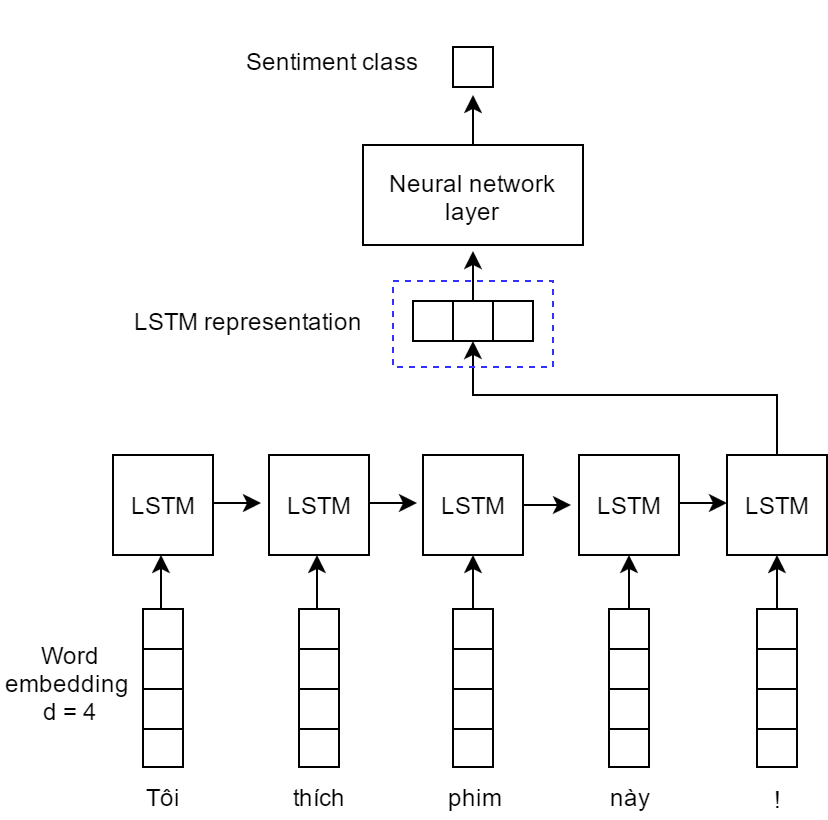

 On applique une couche LSTM avec 100 unités (neurones) et un taux de dropout défini par la variable dropout "hperparam: (qui est généralement un nombre entre 0 et 1). Le dropout est une technique de régularisation qui consiste à désactiver aléatoirement une fraction des neurones pendant l'entraînement afin de réduire le sur-apprentissage (overfitting) en forçant le modèle à ne pas dépendre trop fortement de certains neurones.

In [ ]:
#Model Architecture
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
if bidirectional:
  x = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
else:
  x = LSTM(100,dropout=dropout)(embedded_sequences)
preds = Dense(len(labels_index), activation='softmax')(x)
lstm_model = Model(sequence_input, preds)
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1000, 200)           │       5,731,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,852,705 (22.33 MB)

 Trainable params: 5,852,705 (22.33 MB)

 Non-trainable params: 0 (0.00 B)

Cette section maintentenat configure les callbacks pour l'entraînement du modèle :

ModelCheckpoint : Sauvegarde le modèle à chaque époque où la perte sur la validation est la plus faible.
EarlyStopping : Arrête l'entraînement si la perte de validation n'améliore plus après un certain nombre d'époques (patience).
TensorBoard : Permet la visualisation des performances du modèle pendant l'entraînement via TensorBoard.

In [ ]:
#Callbacks - checkpointer, early stopping and tensorboard
model_name = "RNN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+str(traina)+"-bidrect-"+str(bidirectional)
checkpointer = ModelCheckpoint(model_name + "_model.{epoch:02d}-{val_loss:.2f}.keras", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min', save_weights_only=False)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_rnn = TensorBoard(log_dir='./Graph_RNN', histogram_freq=0,write_graph=True, write_images=True)

## Entraînement du Modèle LSTM avec Callbacks

In [ ]:
#Train Model
stmillis = int(round(time.time() * 1000))
history = lstm_model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping,tensorboard_rnn])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Epoch 1/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.4490 - loss: 1.3927
Epoch 1: val_loss improved from inf to 0.75949, saving model to RNN-0.3-200-Trainable-True-bidrect-False_model.01-0.76.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - acc: 0.4664 - loss: 1.3650 - val_acc: 0.7431 - val_loss: 0.7595
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0.7966 - loss: 0.6457
Epoch 2: val_loss improved from 0.75949 to 0.56458, saving model to RNN-0.3-200-Trainable-True-bidrect-False_model.02-0.56.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - acc: 0.7968 - loss: 0.6454 - val_acc: 0.8110 - val_loss: 0.5646
Epoch 3/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.8415 - loss: 0.4875
Epoch 3: val_loss improved from 0.56458 to 0.52688, saving model to RNN-0.3-200-Trainable-True-bidrect-False_model.03-0.53.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - acc: 0.8417 - loss: 0.4865 - val_acc: 0.8132 - val_loss: 0.5269
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 0

## **Courbes de Précision (Accuracy) et de Perte (Loss)**

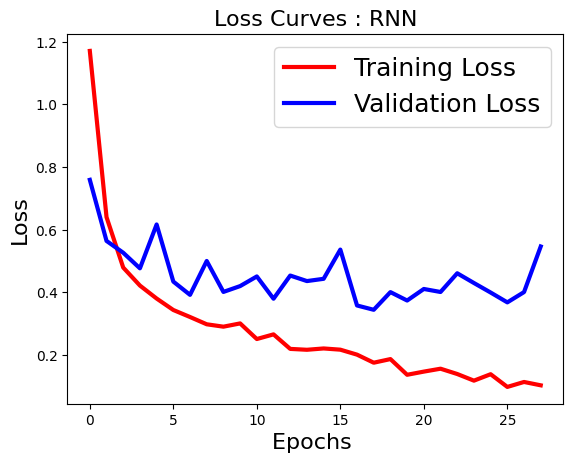

In [ ]:
#Plot loss curve
fig=plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : RNN',fontsize=16)
fig.savefig(model_name+'.png')
plt.show()

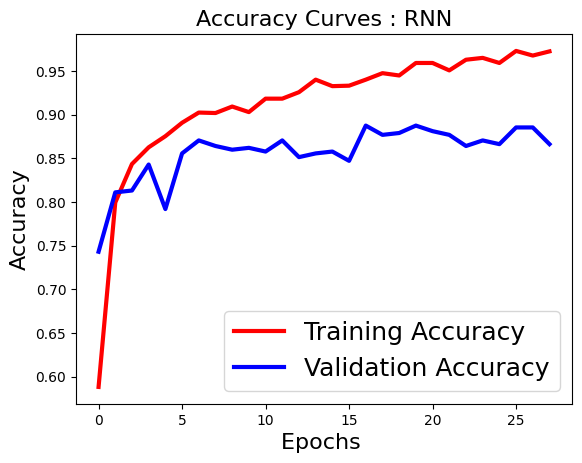

In [ ]:
#Plot accuracy curve
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig.savefig(model_name+'-ACC'+'.png')
plt.show()

### **Je vois un potentiel de surapprentissage, je vais améliorer la précision de validation en ajustant les hyperparamètres.**

## **Optimisation des Hyperparamètres avec Optuna**

1.  **Définition du modèle** : Le modèle LSTM est construit avec des hyperparamètres variés tels que le taux de dropout, si le LSTM est bidirectionnel, la dimension d'intégration, si les embeddings sont entraînables, et le terme de régularisation L2.
    
2.  **Optimisation avec Optuna** :
    
    *   L'optimisation hyperparamétrique est réalisée à l'aide d'Optuna, qui explore différentes valeurs de hyperparamètres pour maximiser la précision sur l'ensemble de validation (val\_acc).
        
    *   La fonction objective définit les hyperparamètres à explorer (par exemple, le taux de dropout entre 0.2 et 0.5, et l'utilisation du LSTM bidirectionnel).
        
    *   Un rappel de EarlyStopping est utilisé pour arrêter l'entraînement dès que la perte de validation ne s'améliore pas.
        
3.  **Résultats de l'optimisation** :
    
    *   Une fois les essais terminés, les meilleurs hyperparamètres sont récupérés, et un modèle final est entraîné avec ces paramètres optimaux.
        
4.  **Planification du Taux d'Apprentissage** :
    
    *   Un LearningRateScheduler est utilisé pour ajuster dynamiquement le taux d'apprentissage (réduire de 10 % tous les 5 époques).
        
5.  **Entraînement avec Callbacks** :
    
    *   Le modèle est ensuite formé sur les données d'entraînement avec les callbacks définis (EarlyStopping et LearningRateScheduler) pour améliorer la convergence du modèle tout en évitant le surapprentissage.
        

Ce processus permet d’optimiser les performances du modèle et d’ajuster le taux d’apprentissage pour un entraînement plus stable.

## **Pourquoi Optuna ??**
Optuna est une bibliothèque d'optimisation d'hyperparamètres qui permet de trouver les meilleurs hyperparamètres pour un modèle de manière automatique et efficace. Voici pourquoi il est utilisé dans ce contexte :

### 1\. **Optimisation Automatique des Hyperparamètres** :

*   L'une des tâches les plus importantes et complexes en apprentissage automatique est la sélection des bons hyperparamètres pour le modèle. Choisir des valeurs optimales pour des hyperparamètres comme le taux de dropout, la dimension des embeddings, ou la régularisation L2 peut grandement influencer les performances du modèle.
    
*   Optuna automatise ce processus en explorant un espace de recherche défini pour optimiser les hyperparamètres et améliorer les performances du modèle.
    

### 2\. **Exploration Efficace de l'Espace de Recherche** :

*   Optuna utilise une approche de recherche **bayésienne** pour explorer l'espace des hyperparamètres. Cela lui permet de trouver plus rapidement les configurations qui maximisent la performance du modèle, en se basant sur les résultats précédents.
    
*   Contrairement à la recherche exhaustive (grid search) ou à la recherche aléatoire (random search), Optuna est plus efficace pour les modèles complexes en se concentrant sur les zones de l'espace de recherche les plus prometteuses.
    

### 3\. **Gestion Dynamique des Essais** :

*   Optuna permet d'arrêter les essais non prometteurs tôt, en fonction de critères comme la performance sur un ensemble de validation. Cela réduit le temps de calcul global.
    
*   Il propose aussi une fonctionnalité d'**early stopping** intégrée, ce qui permet de stopper l'entraînement d'un modèle si les performances ne s'améliorent plus après un certain nombre d'époques.
    

### 4\. **Flexibilité et Intégration Facile** :

*   Optuna peut être intégré facilement avec des frameworks populaires comme Keras et TensorFlow, et il fonctionne bien avec des modèles complexes comme ceux basés sur des réseaux neuronaux profonds (par exemple, LSTM).
    
*   Il est aussi flexible : vous pouvez définir des plages pour les hyperparamètres à explorer (par exemple, dropout entre 0.2 et 0.5) et utiliser des stratégies comme la recherche par catégorie ou la recherche log-uniforme.
    

### 5\. **Suivi des Résultats et Visualisation** :

*   Optuna permet de suivre l'évolution des essais en temps réel et offre des outils de visualisation puissants pour explorer l'impact des hyperparamètres sur la performance du modèle.
    
*   Cela permet de mieux comprendre quelles valeurs d'hyperparamètres influencent le plus la précision ou la perte du modèle.

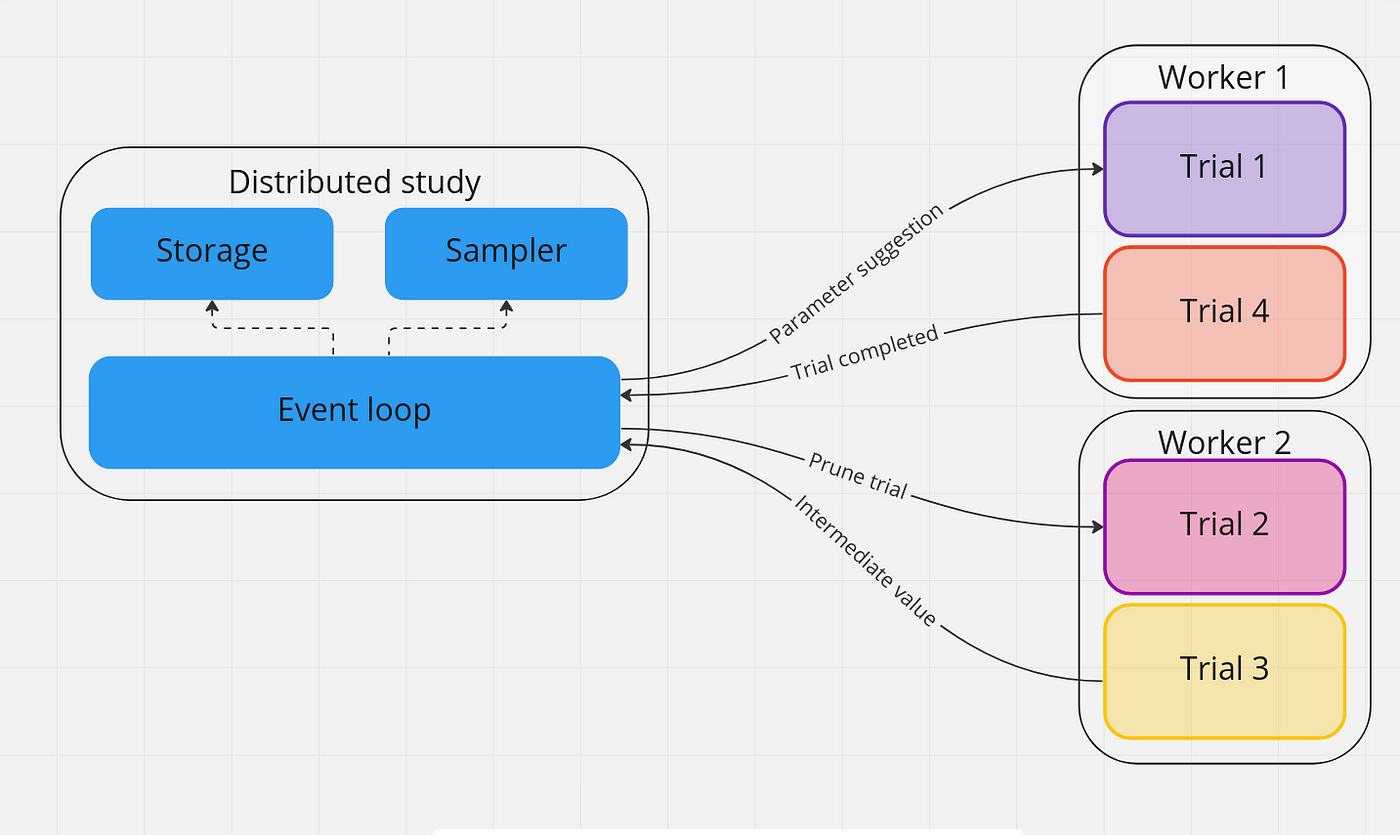

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras import optimizers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras import regularizers
import optuna
from optuna.integration import TFKerasPruningCallback
import tensorflow as tf

def build_model(dropout=0.3, bidirectional=False, embedding_dim=200, trainable=True, l2_reg=0.01):
    # Create the model
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=trainable)(sequence_input)

    if bidirectional:
        x = Bidirectional(LSTM(100, dropout=dropout,
                               kernel_regularizer=regularizers.l2(l2_reg)))(embedding_layer)
    else:
        x = LSTM(100, dropout=dropout,
                 kernel_regularizer=regularizers.l2(l2_reg))(embedding_layer)

    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [ ]:
def objective(trial):
    # Suggest values for the hyperparameters
    dropout = trial.suggest_float('dropout', 0.2, 0.5)  # Explore dropout rates between 0.2 and 0.5
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])  # Explore True/False for bidirectional
    embedding_dim = trial.suggest_categorical('embedding_dim', [200])  # Explore embedding dimensions
    trainable = trial.suggest_categorical('trainable', [True, False])  # Explore trainable/non-trainable embeddings
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Explore l2 regularization strength (between 1e-6 and 1e-2)

    # Build the model with suggested hyperparameters
    model = build_model(dropout=dropout, bidirectional=bidirectional, embedding_dim=embedding_dim, trainable=trainable, l2_reg=l2_reg)

    # Early stopping to prevent overfitting (optional)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # Fit the model
    model.fit(xtrain, ytrain, epochs=25, batch_size=32, validation_data=(xval, yval), callbacks=[early_stopping, TFKerasPruningCallback(trial, monitor='val_loss')])

    # Evaluate the model on validation set
    val_loss, val_acc = model.evaluate(xval, yval)

    # Return the validation accuracy, which we want to maximize
    return val_acc

In [ ]:
study = optuna.create_study(direction='maximize')

# Run optimization for 30 trials
study.optimize(objective, n_trials=30)

[I 2024-12-28 03:52:50,137] A new study created in memory with name: no-name-71e3fdf1-a51e-4612-85cd-e44e379fbabf


Epoch 1/25


<ipython-input-59-1ab0d0f83cc8>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-6, 1e-2)  # Explore l2 regularization strength (between 1e-6 and 1e-2)


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - acc: 0.4792 - loss: 1.3457 - val_acc: 0.7941 - val_loss: 0.5885
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8312 - loss: 0.5499 - val_acc: 0.8174 - val_loss: 0.5982
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8392 - loss: 0.4836 - val_acc: 0.8025 - val_loss: 0.6055
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - acc: 0.8545 - loss: 0.4345 - val_acc: 0.8259 - val_loss: 0.5318
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8154 - loss: 0.5661 - val_acc: 0.8153 - val_loss: 0.6111
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8242 - loss: 0.5253 - val_acc: 0.8068 - val_loss: 0.5948
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8531 - loss: 0.4549 - val_acc: 0.8004 - val_loss: 0.5537
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.8137 - loss: 0.5142


[I 2024-12-28 03:53:21,903] Trial 0 finished with value: 0.8110403418540955 and parameters: {'dropout': 0.42026939747888803, 'bidirectional': True, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 5.520667304682583e-06}. Best is trial 0 with value: 0.8110403418540955.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - acc: 0.4819 - loss: 1.5025 - val_acc: 0.7941 - val_loss: 0.7767
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.7762 - loss: 0.8552 - val_acc: 0.8068 - val_loss: 0.7286
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8306 - loss: 0.6892 - val_acc: 0.8344 - val_loss: 0.6609
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8610 - loss: 0.5871 - val_acc: 0.8174 - val_loss: 0.6882
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8586 - loss: 0.6080 - val_acc: 0.8493 - val_loss: 0.6273
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8648 - loss: 0.5301 - val_acc: 0.8429 - val_loss: 0.6372
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8684 - loss: 0.5276 - val_acc: 0.8408 - val_loss: 0.5986
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8808 - loss: 0.4930 - val_acc: 0.8514 - val_loss: 0.5738
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.8978

[I 2024-12-28 03:53:47,456] Trial 1 finished with value: 0.8662420511245728 and parameters: {'dropout': 0.40470052252514577, 'bidirectional': False, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.0007877319993798858}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - acc: 0.4103 - loss: 1.5798 - val_acc: 0.7622 - val_loss: 0.8386
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8086 - loss: 0.7076 - val_acc: 0.7558 - val_loss: 0.7735
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8185 - loss: 0.6535 - val_acc: 0.7877 - val_loss: 0.7360
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8437 - loss: 0.5752 - val_acc: 0.8386 - val_loss: 0.6209
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8243 - loss: 0.6551 - val_acc: 0.8238 - val_loss: 0.6213
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8596 - loss: 0.5146 - val_acc: 0.8238 - val_loss: 0.6165
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8464 - loss: 0.5517 - val_acc: 0.8301 - val_loss: 0.5911
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8732 - loss: 0.4946 - val_acc: 0.8323 - val_loss: 0.5774
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8751

[I 2024-12-28 03:54:36,446] Trial 2 finished with value: 0.8110403418540955 and parameters: {'dropout': 0.48811850371181836, 'bidirectional': True, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.0003668535156884497}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.4401 - loss: 1.7939 - val_acc: 0.7495 - val_loss: 1.0405
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8090 - loss: 0.8904 - val_acc: 0.7834 - val_loss: 0.8901
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8447 - loss: 0.7645 - val_acc: 0.8344 - val_loss: 0.7780
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8490 - loss: 0.7102 - val_acc: 0.8089 - val_loss: 0.8313
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8272 - loss: 0.7234 - val_acc: 0.8132 - val_loss: 0.7575
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8567 - loss: 0.6393 - val_acc: 0.8110 - val_loss: 0.7487
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8372 - loss: 0.6692 - val_acc: 0.8365 - val_loss: 0.6800
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8657 - loss: 0.5712 - val_acc: 0.8408 - val_loss: 0.6965
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - acc: 0.8604

[I 2024-12-28 03:55:23,617] Trial 3 finished with value: 0.8407643437385559 and parameters: {'dropout': 0.466588324061427, 'bidirectional': False, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.0018022416081826642}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc: 0.4876 - loss: 1.4023 - val_acc: 0.8047 - val_loss: 0.6959
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8135 - loss: 0.6501 - val_acc: 0.8471 - val_loss: 0.5755
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8250 - loss: 0.6136 - val_acc: 0.8429 - val_loss: 0.5913
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8712 - loss: 0.5093 - val_acc: 0.8408 - val_loss: 0.5869
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8616 - loss: 0.4878 - val_acc: 0.8386 - val_loss: 0.5812
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8609 - loss: 0.5162


[I 2024-12-28 03:55:36,496] Trial 4 finished with value: 0.8471337556838989 and parameters: {'dropout': 0.3530298382130447, 'bidirectional': False, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.0003721948067528141}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - acc: 0.4636 - loss: 2.2756 - val_acc: 0.7665 - val_loss: 1.1039
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.7964 - loss: 1.0086 - val_acc: 0.7304 - val_loss: 1.0321
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8043 - loss: 0.8858 - val_acc: 0.7113 - val_loss: 1.0768
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.7888 - loss: 0.9002 - val_acc: 0.8344 - val_loss: 0.7643
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8387 - loss: 0.7015 - val_acc: 0.8217 - val_loss: 0.7713
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8609 - loss: 0.6261 - val_acc: 0.8132 - val_loss: 0.8080
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8605 - loss: 0.6202 - val_acc: 0.8238 - val_loss: 0.7163
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8449 - loss: 0.6078 - val_acc: 0.8068 - val_loss: 0.7168
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8462

[I 2024-12-28 03:56:41,222] Trial 5 finished with value: 0.8471337556838989 and parameters: {'dropout': 0.49165778868545684, 'bidirectional': True, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.0022254839869997934}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.5185 - loss: 1.2756

[I 2024-12-28 03:56:47,889] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - acc: 0.4541 - loss: 3.2118 - val_acc: 0.7558 - val_loss: 1.3859
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8065 - loss: 1.1665 - val_acc: 0.7813 - val_loss: 1.0188
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8488 - loss: 0.8326 - val_acc: 0.8344 - val_loss: 0.7825
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.8795 - loss: 0.6671 - val_acc: 0.8004 - val_loss: 0.8109
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8775 - loss: 0.5908 - val_acc: 0.8365 - val_loss: 0.7194
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.9044 - loss: 0.5089 - val_acc: 0.8535 - val_loss: 0.6790
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.9154 - loss: 0.4650 - val_acc: 0.8238 - val_loss: 0.7583
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8982 - loss: 0.5424 - val_acc: 0.8514 - val_loss: 0.6934
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9390

[I 2024-12-28 03:57:50,003] Trial 7 finished with value: 0.8598726391792297 and parameters: {'dropout': 0.4709654549403632, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.004690132127231753}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc: 0.4638 - loss: 2.2762 - val_acc: 0.7665 - val_loss: 1.2938
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8319 - loss: 1.0753 - val_acc: 0.8599 - val_loss: 0.8950
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8841 - loss: 0.7616 - val_acc: 0.8662 - val_loss: 0.7445
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8916 - loss: 0.6214 - val_acc: 0.8620 - val_loss: 0.7536
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8730 - loss: 0.6718 - val_acc: 0.8620 - val_loss: 0.6551
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9244 - loss: 0.4850 - val_acc: 0.8323 - val_loss: 0.7416
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - acc: 0.9424 - loss: 0.4279 - val_acc: 0.8217 - val_loss: 0.7480
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9156 - loss: 0.4853 - val_acc: 0.8641 - val_loss: 0.6089
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9489

[I 2024-12-28 03:58:21,165] Trial 8 finished with value: 0.8641188740730286 and parameters: {'dropout': 0.4025582839771681, 'bidirectional': False, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.0042804862515726985}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.5478 - loss: 1.2322

[I 2024-12-28 03:58:25,170] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.5094 - loss: 1.2571

[I 2024-12-28 03:58:29,122] Trial 10 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.4760 - loss: 3.2177 - val_acc: 0.7176 - val_loss: 1.8223
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.7847 - loss: 1.4014 - val_acc: 0.8365 - val_loss: 1.0177
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8511 - loss: 0.9056 - val_acc: 0.8471 - val_loss: 0.8315
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8897 - loss: 0.7139 - val_acc: 0.8471 - val_loss: 0.7607
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - acc: 0.8863 - loss: 0.6664 - val_acc: 0.7813 - val_loss: 1.0293
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.8738 - loss: 0.7149 - val_acc: 0.8493 - val_loss: 0.7912
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - acc: 0.9370 - loss: 0.4773 - val_acc: 0.8599 - val_loss: 0.7211
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9538 - loss: 0.4082 - val_acc: 0.8747 - val_loss: 0.6317
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.9587

[I 2024-12-28 03:59:00,155] Trial 11 finished with value: 0.8598726391792297 and parameters: {'dropout': 0.3953161886787934, 'bidirectional': False, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.00931053441831654}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.4882 - loss: 1.4193

[I 2024-12-28 03:59:04,179] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.4763 - loss: 1.5743

[I 2024-12-28 03:59:08,123] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.4626 - loss: 1.3618

[I 2024-12-28 03:59:12,810] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.4369 - loss: 1.3549

[I 2024-12-28 03:59:16,804] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.5090 - loss: 3.1951 - val_acc: 0.8195 - val_loss: 1.3544
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8412 - loss: 1.1736 - val_acc: 0.8344 - val_loss: 0.9268
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8555 - loss: 0.8272 - val_acc: 0.8174 - val_loss: 0.8857
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8326 - loss: 0.8422 - val_acc: 0.7792 - val_loss: 0.9288
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8498 - loss: 0.7647 - val_acc: 0.8684 - val_loss: 0.7056
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8018 - loss: 0.8727 - val_acc: 0.7537 - val_loss: 1.1737
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8312 - loss: 0.8244 - val_acc: 0.8110 - val_loss: 0.8445
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8157 - loss: 0.8797 - val_acc: 0.8259 - val_loss: 0.7938
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8443 - loss: 0.

[I 2024-12-28 03:59:35,998] Trial 16 finished with value: 0.8450106382369995 and parameters: {'dropout': 0.2983270772719929, 'bidirectional': False, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.009412509388028375}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.4472 - loss: 1.5571

[I 2024-12-28 03:59:40,057] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc: 0.5156 - loss: 2.0421 - val_acc: 0.7898 - val_loss: 1.0898
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8172 - loss: 0.9819 - val_acc: 0.8280 - val_loss: 0.8726
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8502 - loss: 0.7878 - val_acc: 0.8493 - val_loss: 0.7414
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8620 - loss: 0.6900 - val_acc: 0.8535 - val_loss: 0.6920
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8595 - loss: 0.6644 - val_acc: 0.8386 - val_loss: 0.7115
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - acc: 0.8226 - loss: 0.7557 - val_acc: 0.7495 - val_loss: 0.9006
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.8133 - loss: 0.7863 - val_acc: 0.8047 - val_loss: 0.7874
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.8125 - loss: 0.7531


[I 2024-12-28 03:59:57,056] Trial 18 finished with value: 0.7940552234649658 and parameters: {'dropout': 0.29243678927412575, 'bidirectional': False, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.00348289434168566}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.4755 - loss: 1.4826

[I 2024-12-28 04:00:01,019] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - acc: 0.5083 - loss: 1.3095

[I 2024-12-28 04:00:05,017] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - acc: 0.5219 - loss: 2.8534 - val_acc: 0.6985 - val_loss: 1.5227
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.7787 - loss: 1.1926 - val_acc: 0.8153 - val_loss: 0.9486
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8690 - loss: 0.7325 - val_acc: 0.8153 - val_loss: 0.8463
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.8653 - loss: 0.6923 - val_acc: 0.8514 - val_loss: 0.7421
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.9154 - loss: 0.5201 - val_acc: 0.8493 - val_loss: 0.6666
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.9222 - loss: 0.4788 - val_acc: 0.8450 - val_loss: 0.6927
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9451 - loss: 0.3978 - val_acc: 0.8705 - val_loss: 0.6179
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9492 - loss: 0.3510 - val_acc: 0.8301 - val_loss: 0.7630
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9196

[I 2024-12-28 04:00:50,086] Trial 21 finished with value: 0.8641188740730286 and parameters: {'dropout': 0.4117938507388494, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.003966877952195925}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - acc: 0.4430 - loss: 3.0094 - val_acc: 0.8301 - val_loss: 1.1988
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8193 - loss: 1.1019 - val_acc: 0.8471 - val_loss: 0.8489
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8665 - loss: 0.7594 - val_acc: 0.7028 - val_loss: 1.1961
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8529 - loss: 0.7461 - val_acc: 0.7877 - val_loss: 0.8431
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8885 - loss: 0.7132 - val_acc: 0.8323 - val_loss: 0.7972
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9091 - loss: 0.5894 - val_acc: 0.8493 - val_loss: 0.7468
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9379 - loss: 0.4866 - val_acc: 0.8047 - val_loss: 0.8800
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9101 - loss: 0.5483 - val_acc: 0.8535 - val_loss: 0.6870
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9469

[I 2024-12-28 04:01:48,041] Trial 22 finished with value: 0.8577494621276855 and parameters: {'dropout': 0.41342598617318754, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.004172340427479515}. Best is trial 1 with value: 0.8662420511245728.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.4684 - loss: 2.0180

[I 2024-12-28 04:01:54,876] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - acc: 0.4926 - loss: 3.2055 - val_acc: 0.7813 - val_loss: 1.3551
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8289 - loss: 1.1621 - val_acc: 0.8259 - val_loss: 0.9876
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8783 - loss: 0.8342 - val_acc: 0.8450 - val_loss: 0.7922
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8943 - loss: 0.6791 - val_acc: 0.8344 - val_loss: 0.8092
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.8341 - loss: 0.8119 - val_acc: 0.8047 - val_loss: 0.9494
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9030 - loss: 0.6664 - val_acc: 0.8493 - val_loss: 0.7801
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9312 - loss: 0.5414 - val_acc: 0.8705 - val_loss: 0.7576
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.9525 - loss: 0.4556 - val_acc: 0.8599 - val_loss: 0.7380
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9673

[I 2024-12-28 04:03:39,207] Trial 24 finished with value: 0.8959660530090332 and parameters: {'dropout': 0.3265954213792023, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.004911153784449281}. Best is trial 24 with value: 0.8959660530090332.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - acc: 0.4671 - loss: 4.8303 - val_acc: 0.8110 - val_loss: 1.5672
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8459 - loss: 1.2773 - val_acc: 0.8238 - val_loss: 0.9267
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8416 - loss: 0.8482 - val_acc: 0.8301 - val_loss: 0.8047
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8961 - loss: 0.6373 - val_acc: 0.7749 - val_loss: 0.9056
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8971 - loss: 0.6160 - val_acc: 0.8514 - val_loss: 0.6943
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.8679 - loss: 0.7263 - val_acc: 0.8662 - val_loss: 0.7351
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9281 - loss: 0.5057 - val_acc: 0.8577 - val_loss: 0.6650
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9457 - loss: 0.4126 - val_acc: 0.8450 - val_loss: 0.7323
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.9623

[I 2024-12-28 04:05:14,814] Trial 25 finished with value: 0.8704883456230164 and parameters: {'dropout': 0.3144309282355433, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.009241858319219736}. Best is trial 24 with value: 0.8959660530090332.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - acc: 0.4438 - loss: 5.0696 - val_acc: 0.7431 - val_loss: 1.7811
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.7692 - loss: 1.5294 - val_acc: 0.8280 - val_loss: 0.9629
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8344 - loss: 0.8987 - val_acc: 0.8301 - val_loss: 0.8106
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8530 - loss: 0.7461 - val_acc: 0.8386 - val_loss: 0.7662
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8653 - loss: 0.6687 - val_acc: 0.8323 - val_loss: 0.8107
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8408 - loss: 0.7186 - val_acc: 0.8132 - val_loss: 0.8250
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8767 - loss: 0.6290 - val_acc: 0.8344 - val_loss: 0.7406
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - acc: 0.8594 - loss: 0.6417 - val_acc: 0.8408 - val_loss: 0.6806
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - acc: 0.8333

[I 2024-12-28 04:06:04,197] Trial 26 finished with value: 0.8046709299087524 and parameters: {'dropout': 0.31387635346098297, 'bidirectional': True, 'embedding_dim': 200, 'trainable': False, 'l2_reg': 0.009912000583518243}. Best is trial 24 with value: 0.8959660530090332.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.5539 - loss: 1.8411

[I 2024-12-28 04:06:11,123] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.5110 - loss: 1.3223

[I 2024-12-28 04:06:17,724] Trial 28 pruned. Trial was pruned at epoch 0.


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.4972 - loss: 1.6244

[I 2024-12-28 04:06:24,348] Trial 29 pruned. Trial was pruned at epoch 0.


In [ ]:
# Get the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# You can also get the best value for the objective (e.g., val_loss)
print("Best validation acc: ", study.best_value)


Best hyperparameters:  {'dropout': 0.3265954213792023, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.004911153784449281}
Best validation acc:  0.8959660530090332


In [ ]:
best_model_params = {'dropout': 0.3144309282355433, 'bidirectional': True, 'embedding_dim': 200, 'trainable': True, 'l2_reg': 0.009241858319219736}
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define a learning rate decay function
def lr_schedule(epoch, lr):
    # Example: Reduce the learning rate by a factor of 0.9 every 5 epochs
    if epoch % 5 == 0 and epoch > 0:
        return lr * 0.9
    return lr
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor the validation accuracy
    patience=10,  # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation accuracy
    verbose=1  # Print messages when early stopping is triggered
)
# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

# Build the model with the best parameters
best_model = build_model(**best_model_params)

# Compile the model with the optimizer
best_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the best model with the callback
best_model.fit(
    xtrain, ytrain,
    epochs=50,
    batch_size=32,
    validation_data=(xval, yval),
    callbacks=[lr_scheduler,early_stopping_callback]  # Include both callbacks
)




Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.4701 - loss: 4.8130 - val_accuracy: 0.7983 - val_loss: 1.6276 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8290 - loss: 1.3096 - val_accuracy: 0.7771 - val_loss: 1.0842 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8324 - loss: 0.9273 - val_accuracy: 0.8238 - val_loss: 0.8895 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8895 - loss: 0.7205 - val_accuracy: 0.7983 - val_loss: 0.9074 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.00100000004749745

# **we acheived 0.91088 as best val accuracy** (EPOCH 28)

In [ ]:
best_model.save('best_model.keras')  # Save in keras

In [ ]:
# Save model config as json
model_json = best_model.to_json()
with open('best_model' + ".json", "w") as json_file:
    json_file.write(model_json)

## Évaluation de la Précision du Modèle sur les Données de Test

Ce script évalue la précision d'un modèle de classification sur des données de test. Il effectue les étapes suivantes :

1.  **Prétraitement des Données de Test** : Les textes de test sont transformés en séquences d'indices et sont mis à une longueur uniforme.
    
2.  **Conversion des Étiquettes en Categorical** : Les étiquettes de test sont converties en format "one-hot".
    
3.  **Évaluation du Modèle** : Le modèle est évalué sur les données de test pour obtenir la précision.
    
4.  **Affichage de la Précision** : La précision du modèle est affichée.
    

**Exemple de résultat** : Le modèle a une précision de **90.32%** sur les données de test.

## le nom de notre modele est : **best_model**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def evaluate_accuracy(model, X_test, y_test, tokenizer, MAX_SEQUENCE_LENGTH):
    """
    Evaluate model accuracy on test data

    Parameters:
    -----------
    model : keras.Model
        Trained model to evaluate
    X_test : array-like
        Test features (text data)
    y_test : array-like
        Test labels
    tokenizer : keras.preprocessing.text.Tokenizer
        Fitted tokenizer used during training
    MAX_SEQUENCE_LENGTH : int
        Maximum sequence length used during training

    Returns:
    --------
    float
        Accuracy score (0-1)
    """
    # Convert test texts to sequences
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Pad sequences
    X_test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Convert test labels to categorical
    y_test_cat = to_categorical(np.asarray(y_test))

    # Get accuracy
    _, accuracy = model.evaluate(X_test_padded, y_test_cat, verbose=0)

    return accuracy

# Example usage:
accuracy = evaluate_accuracy(
    model=best_model,
    X_test=test_text,
    y_test=y_test,
    tokenizer=tokenizer,
    MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH
)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9032


In [ ]:
from tensorflow.keras.models import load_model
best_model_uploaded = load_model("/content/best_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
accuracy = evaluate_accuracy(
    model=best_model_uploaded,
    X_test=test_text,
    y_test=y_test,
    tokenizer=tokenizer,
    MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH
)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9032


# **Les cellules suivantes sont destinées à tester de manière aléatoire de nouvelles données de test pour les classifier. J'ai également confirmé qu'enregistrer le modèle sous forme de Keras ne pose pas de problèmes. Ainsi, j'ai enregistré le modèle, puis je l'ai chargé et testé. De plus, j'ai ajouté des fonctions permettant de sauvegarder le tokenizer (en soulignant l'importance d'un tokenizer spécifique au modèle) et le modèle sur Google Drive, ainsi qu'une autre fonction pour récupérer ces éléments depuis Drive.**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_single_text(text, model, tokenizer, MAX_SEQUENCE_LENGTH):
    """
    Predict the category for a single text input

    Parameters:
    -----------
    text : str
        Input text to classify
    model : keras.Model
        Trained model to use for prediction
    tokenizer : keras.preprocessing.text.Tokenizer
        Fitted tokenizer used during training
    MAX_SEQUENCE_LENGTH : int
        Maximum sequence length used during training

    Returns:
    --------
    str
        Predicted label
    float
        Confidence score
    """
    # Convert labels_index to a reverse mapping
    labels = {0: 'business', 1: 'entertainment', 2: 'politics',
             3: 'sport', 4: 'tech'}

    # Preprocess the text
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Get prediction
    prediction = model.predict(padded_sequence, verbose=0)

    # Get predicted class and confidence
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    return labels[predicted_class], confidence

# Test the sample
sample_text = "weve discount macbook pro released"
predicted_label, confidence = predict_single_text(
    text=sample_text,
    model=best_model,
    tokenizer=tokenizer,
    MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH
)

print(f"Text: '{sample_text}'")
print(f"Predicted Category: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

Text: 'weve discount macbook pro released'
Predicted Category: tech
Confidence: 72.76%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_single_text(text, model, tokenizer, MAX_SEQUENCE_LENGTH):
    """
    Predict the category for a single text input

    Parameters:
    -----------
    text : str
        Input text to classify
    model : keras.Model
        Trained model to use for prediction
    tokenizer : keras.preprocessing.text.Tokenizer
        Fitted tokenizer used during training
    MAX_SEQUENCE_LENGTH : int
        Maximum sequence length used during training

    Returns:
    --------
    str
        Predicted label
    float
        Confidence score
    """
    # Convert labels_index to a reverse mapping
    labels = {0: 'business', 1: 'entertainment', 2: 'politics',
             3: 'sport', 4: 'tech'}

    # Preprocess the text
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Get prediction
    prediction = model.predict(padded_sequence, verbose=0)

    # Get predicted class and confidence
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    return labels[predicted_class], confidence

# This is completely new text
sample_text = """Artificial Intelligence (AI) has become a cornerstone of innovation in modern technology,
driving advancements across industries. From machine learning algorithms that analyze vast datasets to natural
language processing models like GPT transforming communication, AI is reshaping how businesses operate. AI-powered systems enhance
 decision-making by uncovering patterns and insights previously beyond human reach, while automation reduces operational inefficiencies.
  Emerging technologies like edge computing and AI in Internet of Things (IoT) devices further enable real-time analytics, empowering smart cities,
   autonomous vehicles, and personalized healthcare. As AI continues to evolve, ethical considerations and sustainable implementation remain critical to
    ensuring its benefits are accessible and equitable."""


predicted_label, confidence = predict_single_text(
    text=sample_text,
    model=best_model,
    tokenizer=tokenizer,
    MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH
)
print("This is a random text from the web and our model predict its class well")
print(f"Text: '{sample_text}'")
print(f"Predicted Category: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

This is a random text from the web and our model predict its class well
Text: 'Artificial Intelligence (AI) has become a cornerstone of innovation in modern technology, 
driving advancements across industries. From machine learning algorithms that analyze vast datasets to natural 
language processing models like GPT transforming communication, AI is reshaping how businesses operate. AI-powered systems enhance
 decision-making by uncovering patterns and insights previously beyond human reach, while automation reduces operational inefficiencies.
  Emerging technologies like edge computing and AI in Internet of Things (IoT) devices further enable real-time analytics, empowering smart cities,
   autonomous vehicles, and personalized healthcare. As AI continues to evolve, ethical considerations and sustainable implementation remain critical to
    ensuring its benefits are accessible and equitable.'
Predicted Category: tech
Confidence: 99.28%


## **Chaque modèle de traitement du langage naturel (NLP) doit être accompagné de son tokenizer pour garantir que les données textuelles sont correctement préparées avant d'être passées au modèle.**

Un tokenizer transforme les textes en séquences de nombres, en attribuant un identifiant unique à chaque mot ou expression. Comme le modèle a été entraîné avec un tokenizer spécifique, il est crucial de réutiliser exactement ce même tokenizer lors de l'inférence (prédiction). Si un autre tokenizer est utilisé, les données d'entrée seront transformées différemment, ce qui peut entraîner des erreurs et des prédictions incorrectes.

## just saving to my drive

In [ ]:
import pickle
import os
from tensorflow.keras.models import save_model

def save_model_components(model, tokenizer, save_path='model_files'):
    """
    Save the trained model and tokenizer to disk

    Parameters:
    -----------
    model : keras.Model
        Trained model to save
    tokenizer : keras.preprocessing.text.Tokenizer
        Fitted tokenizer to save
    save_path : str
        Directory path where to save the files
    """
    # Create directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Save the model
    model_path = os.path.join(save_path, 'text_classifier_model.keras')
    save_model(model, model_path)

    # Save the tokenizer
    tokenizer_path = os.path.join(save_path, 'tokenizer.pickle')
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Model saved to: {model_path}")
    print(f"Tokenizer saved to: {tokenizer_path}")

# Example usage:
save_model_components(
    model=best_model,
    tokenizer=tokenizer,
    save_path='gdrive/MyDrive/text_classifier'  # For Google Drive
)

Model saved to: gdrive/MyDrive/text_classifier/text_classifier_model.keras
Tokenizer saved to: gdrive/MyDrive/text_classifier/tokenizer.pickle


# Comment Je charge simplement le modèle depuis Drive et le tester (a implementer dans le backend ) ?

In [ ]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_and_predict(text, model_path, tokenizer_path, max_sequence_length):
    """
    Load saved model and tokenizer, then make a prediction

    Parameters:
    -----------
    text : str
        Text to classify
    model_path : str
        Path to saved model
    tokenizer_path : str
        Path to saved tokenizer
    max_sequence_length : int
        Maximum sequence length used during training
    """
    # Load model
    model = load_model(model_path)

    # Load tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Define label mapping
    labels = {
        0: 'business',
        1: 'entertainment',
        2: 'politics',
        3: 'sport',
        4: 'tech'
    }

    # Preprocess the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Get prediction
    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]

    return labels[predicted_class], confidence

# Example usage:
# Replace these paths with your actual saved model and tokenizer paths
model_path = 'gdrive/MyDrive/text_classifier/text_classifier_model.keras'
tokenizer_path = 'gdrive/MyDrive/text_classifier/tokenizer.pickle'

# Test with a sample text
sample_text = "weve discount macbook pro released"
predicted_label, confidence = load_and_predict(
    text=sample_text,
    model_path=model_path,
    tokenizer_path=tokenizer_path,
    max_sequence_length=MAX_SEQUENCE_LENGTH  # Use the same value as during training
)

print(f"Text: '{sample_text}'")
print(f"Predicted Category: {predicted_label}")
print(f"Confidence: {confidence:.2%}")

# You can try more examples:
test_texts = [
    "weve discount macbook pro released",
    "the latest football match ended in controversy",
    "new economic policy announced by government",
    "movie star wins major award at festival"
]

print("\nTesting multiple examples:")
for text in test_texts:
    label, conf = load_and_predict(
        text=text,
        model_path=model_path,
        tokenizer_path=tokenizer_path,
        max_sequence_length=MAX_SEQUENCE_LENGTH
    )
    print(f"\nText: '{text}'")
    print(f"Predicted Category: {label}")
    print(f"Confidence: {conf:.2%}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Text: 'weve discount macbook pro released'
Predicted Category: tech
Confidence: 46.59%

Testing multiple examples:

Text: 'weve discount macbook pro released'
Predicted Category: tech
Confidence: 73.40%

Text: 'the latest football match ended in controversy'
Predicted Category: sport
Confidence: 54.09%

Text: 'new economic policy announced by government'
Predicted Category: business
Confidence: 78.35%

Text: 'movie star wins major award at festival'
Predicted Category: entertainment
Confidence: 99.62%


## Modification pour avoir les proba pour chaque classe

In [ ]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 25000
def load_and_predict(text, model_path, tokenizer_path, max_sequence_length):
    """
    Load saved model and tokenizer, then make a prediction with class probabilities.

    Parameters:
    -----------
    text : str
        Text to classify
    model_path : str
        Path to saved model
    tokenizer_path : str
        Path to saved tokenizer
    max_sequence_length : int
        Maximum sequence length used during training
    """
    # Load model
    model = load_model(model_path)

    # Load tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Define label mapping
    labels = {
        0: 'business',
        1: 'entertainment',
        2: 'politics',
        3: 'sport',
        4: 'tech'
    }

    # Preprocess the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    # Get prediction
    prediction = model.predict(padded_sequence, verbose=0)[0]

    # Print each class with its probability
    print(f"Text: '{text}'")
    print("Class probabilities:")
    for idx, prob in enumerate(prediction):
        print(f"  {labels[idx]}: {prob:.2%}")

    # Determine the predicted class
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]

    return labels[predicted_class], confidence

# Example usage:
# Replace these paths with your actual saved model and tokenizer paths
model_path = 'gdrive/MyDrive/text_classifier/text_classifier_model.keras'
tokenizer_path = 'gdrive/MyDrive/text_classifier/tokenizer.pickle'

# Test with a sample text
sample_text = "movie star wins major award at festival"
predicted_label, confidence = load_and_predict(
    text=sample_text,
    model_path=model_path,
    tokenizer_path=tokenizer_path,
    max_sequence_length=MAX_SEQUENCE_LENGTH  # Use the same value as during training
)

print(f"Predicted Category: {predicted_label}")
print(f"Confidence: {confidence:.2%}")



Text: 'movie star wins major award at festival'
Class probabilities:
  business: 0.08%
  entertainment: 99.73%
  politics: 0.07%
  sport: 0.09%
  tech: 0.02%
Predicted Category: entertainment
Confidence: 99.73%


**47% as confidense is good when we have 5 classes to classify**

## MODEL PLOT

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)


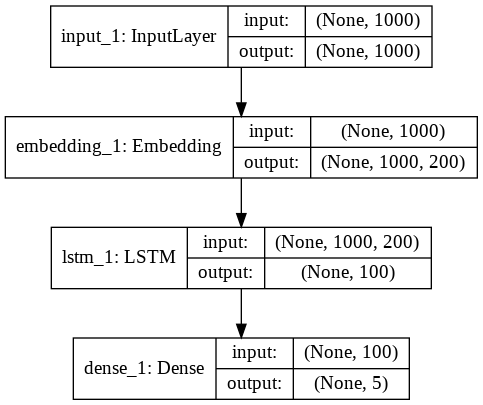

In [ ]:
from PIL import Image
display(Image.open('rnn_model.png'))